# Technical parts

In [1]:
# Global Variables
articles_embeddings_path = '../data/news-portal-user-interactions-by-globocom/articles_embeddings.pickle'
articles_metadata_path = '../data/news-portal-user-interactions-by-globocom/articles_metadata.csv'
clicks_sample_path = '../data/news-portal-user-interactions-by-globocom/clicks_sample.csv'
clicks_folder = '../data/news-portal-user-interactions-by-globocom/clicks/'
interests_path = '../data/interests.csv'

In [2]:
# Imports
import os
import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as mpl
from random import sample


# Personal library imports:
import sys; sys.path.insert(0, '../../lib2')
import utils as u
import stats as s
%load_ext magic_skip
%load_ext autoreload
%autoreload 2


# Recommender library
from surprise import Dataset, SVD, Reader, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from scipy import spatial
from sklearn.metrics.pairwise import euclidean_distances

# Data

In [3]:
articles = pd.read_csv(articles_metadata_path)

display(articles.head())
print('Shape:', articles.shape)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


Shape: (364047, 5)


In [5]:
clicks = []

paths = os.listdir(clicks_folder)
u.eta(step='begin', length=len(paths), text='Loading clicks')
for path in paths:
    clicks.append(pd.read_csv(clicks_folder + path))
    u.eta()
u.eta(step='end')

clicks = pd.concat(clicks)

display(clicks.head())
print('Shape:', clicks.shape)

Loading clicks ran in 0min 2sec                                                                                 


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,266512,1508070980213459,1508070980000,2,74722,1508072399889,4,3,2,1,21,4
1,266512,1508070980213459,1508070980000,2,74702,1508072429889,4,3,2,1,21,4
2,309167,1508070989131460,1508070989000,3,337143,1508071659863,4,3,2,1,25,1
3,309167,1508070989131460,1508070989000,3,237822,1508071825360,4,3,2,1,25,1
4,309167,1508070989131460,1508070989000,3,284154,1508071855360,4,3,2,1,25,1


Shape: (2988181, 12)


# Exploratory analysis

### Users

In [6]:
# Exec time: 3m

users = clicks.drop(columns=['session_id', 'session_start', 'session_size', 'click_article_id', 'click_timestamp', 'click_environment']).groupby(by='user_id').mean().reset_index()
users['click_deviceGroup'] = users['click_deviceGroup'].astype(int)
users['click_os'] = users['click_os'].astype(int)
users['click_country'] = users['click_country'].astype(int)
users['click_region'] = users['click_region'].astype(int)
users['click_referrer_type'] = users['click_referrer_type'].astype(int)
display(users.head())
print('Shape:', users.shape)

,user_id,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,3,20,1,20,2
1,1,1,17,1,16,2
2,2,1,17,1,24,2
3,3,3,2,1,21,1
4,4,1,17,1,16,1


Shape: (322897, 6)


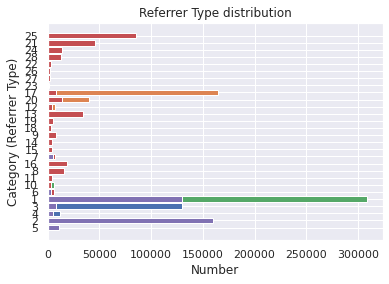

In [7]:
s.histogram(users['click_deviceGroup'], 'Device Group', 'Device Group')
s.histogram(users['click_os'], 'Operating System', 'Operating System')
s.histogram(users['click_country'], 'Country', 'Country')
s.histogram(users['click_region'], 'Region', 'Region')
s.histogram(users['click_referrer_type'], 'Referrer Type', 'Referrer Type')

### Articles

In [8]:
print('Article count:', len(clicks['click_article_id'].unique()))

Article count: 46033


<AxesSubplot:>

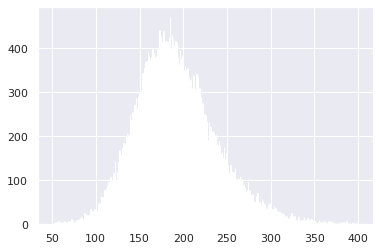

In [9]:
read_articles = clicks['click_article_id'].unique()
articles = articles[[row['article_id'] in read_articles for _, row in articles.iterrows()]]
articles[(articles['words_count'] < 400) & (articles['words_count'] > 50)]['words_count'].hist(bins=len(articles['words_count'].unique()))

<AxesSubplot:title={'center':'Articles length distribution'}, xlabel='Article length', ylabel='Count'>

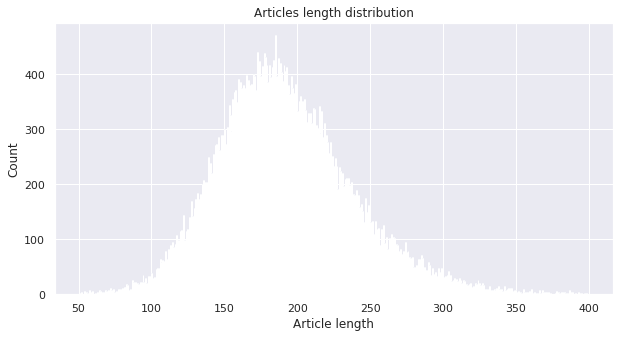

In [10]:
mpl.figure(figsize=(10, 5))
mpl.title('Articles length distribution')
mpl.xlabel('Article length')
mpl.ylabel('Count')
articles[(articles['words_count'] < 400) & (articles['words_count'] > 50)]['words_count'].hist(bins=len(articles['words_count'].unique()))


### Sessions

In [11]:
# Exec time: 50s

sessions = clicks[['session_id', 'session_size']].groupby(by='session_id').mean()

In [12]:
print('Average session size:', round(sessions['session_size'].mean(), 3))

Average session size: 2.85


### Activity time

In [13]:
times = pd.DataFrame()

times['date'] = pd.to_datetime(clicks['click_timestamp'], unit='ms')
times['weekday'] = [x.isoweekday() for x in times['date']]
times['hours'] = [x.hour for x in times['date']]

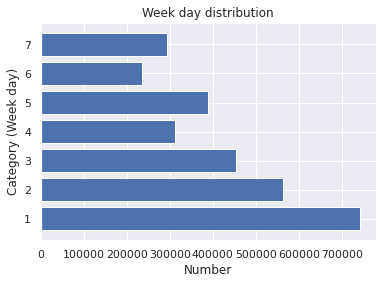

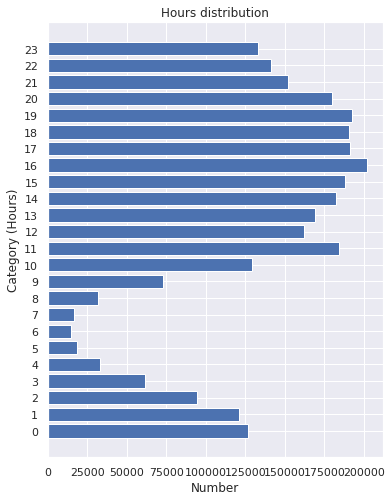

In [15]:
s.histogram(times['weekday'], 'Week day', 'Week day', sort='index')
mpl.figure(figsize=(6, 8))
s.histogram(times['hours'], 'Hours', 'Hours', sort='index')

### Interactions

Users with more than 50 clicks: 6365 (1.97%)


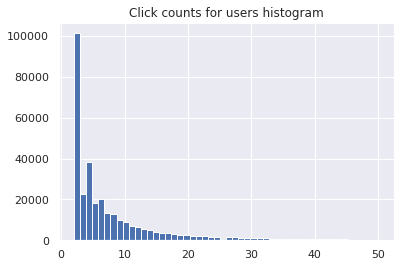

In [16]:
interactions = clicks[['user_id', 'click_deviceGroup']].groupby('user_id').count()

many_click_users = len(interactions[interactions['click_deviceGroup'] > 50])
total = len(interactions)
print('Users with more than 50 clicks:', many_click_users, '(' + u.percent(many_click_users / total) + ')')

interactions_for_graph = interactions[interactions['click_deviceGroup'] <= 50]

mpl.title('Click counts for users histogram')
z = interactions_for_graph['click_deviceGroup'].hist(bins=50)


# Collaborative Filtering

Using only pure collaborative filtering, with no content base property at all is difficult in this case: we do not have ratings for users, articles, but only clicks. The goal would be to know which article a user likes. We have tried to deduct the preferences according to that clicks, but the problem we have is that only one click on an article does not mean the user does not like the article compared to multiple clicks on an article. It can also be linked to the length of the article, the complexity, the subjects, the informations displayed in this article etc. So with the information provided we are not able to deduct the users preferences only based on the clicks.


The strategy I chose to use is to incorporate a content base feature along the collaborative filtering. That makes the next strategy a bit of an hybrid one, but since we can not make it pure Collaborative filtering, it is the best I happen to try.

I will proceed as the following:
According to the clicks, we know what article the user checks and thus the category he looks the most, so we are going to count how much articles for each categories the user likes, and use the population to analyse which new category could please the user.

### First, we look which articles the user is interested in, not depending on click number, according to previous explaination

In [17]:
clicks = clicks[['user_id', 'click_article_id']].drop_duplicates()

display(clicks.head())
print('Shape:', clicks.shape)

,user_id,click_article_id
0,266512,74722
1,266512,74702
2,309167,337143
3,309167,237822
4,309167,284154


Shape: (2950710, 2)


### Second we can find the article category related to each line, thanks to the articles table

In [18]:
clicks = clicks.merge(articles[['article_id', 'category_id']], left_on='click_article_id', right_on='article_id', how='left')
clicks = clicks.drop(columns=['click_article_id'])

display(clicks.head())
print('Shape:', clicks.shape)

,user_id,article_id,category_id
0,266512,74722,142
1,266512,74702,142
2,309167,337143,437
3,309167,237822,375
4,309167,284154,412


Shape: (2950710, 3)


### Third, we can count how much time a user has been interested in a category

In [19]:
interests = clicks.groupby(['user_id', 'category_id']).count().reset_index().rename(columns={'article_id': 'count'})

print('Categories number:', len(interests['category_id'].unique()))
print('Total interests:', interests['count'].sum())
print('Max category interested by a user:', interests['count'].max())

display(interests.head())
print('Shape:', interests.shape)

Categories number: 316
Total interests: 2950710
Max category interested by a user: 530


,user_id,category_id,count
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1


Shape: (1882302, 3)


### Create Ratings

Given these counts, I will take the 5 most appreciated categories for each user and rate consequently: 5 is the prefered category for a user, 1 is the 5th appreciated category for a user. As an precision, if the user only looked at 2 categories, they will be rated as 5 and 4. He will not have a 3, 2, 1 rated categories.

In [20]:
if os.path.exists(interests_path): interests = pd.read_csv(interests_path)
else:
    interests['rate'] = pd.NA

    interests = interests.set_index(['user_id', 'category_id'])
    user_ids = interests.index.get_level_values('user_id').unique().tolist()

    u.eta(step='begin', length=len(user_ids), text='Attributing rates')
    for user_id in user_ids:
        user_interests = interests.loc[user_id].sort_values(by='count').reset_index()

        for i in range(0, min(5, len(user_interests))):
            interests.loc[user_id, user_interests.at[i, 'category_id']] = 5 - i

        u.eta()
    u.eta(step='end')

    interests = interests.dropna().reset_index()

    display(interests.sample(10))
    print('Shape:', interests.shape)

    interests.to_csv(interests_path, index=False)


Attributing rates ran in 12min 53sec                                                                                  


,user_id,category_id,count,rate
367920,88552,430,2,2
91830,21144,247,4,4
365385,87906,323,1,1
96797,22299,399,4,4
1020837,281375,213,2,2
815331,212444,437,2,2
585690,144535,281,3,3
510683,125063,118,4,4
1117181,320712,375,4,4
843311,221345,247,5,5


Shape: (1121763, 4)


### Using Surprise, we can train a model

In [21]:
# to surprise format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(interests[['user_id', 'category_id', 'rate']], reader)

# train test split, for later
train, test = train_test_split(data, test_size=0.2)

### Find best parameters with grid search

In [22]:
### Find best params ###

# Params to search
param_grid = {"n_epochs": [2, 7], "lr_all": [0.005, 0.01], "reg_all": [0.8, 0.12]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

# Searching
gs.fit(data)

# Best RMSE score
print(gs.best_score["rmse"])

# Combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

1.3582454266647537
{'n_epochs': 7, 'lr_all': 0.005, 'reg_all': 0.8}


### Train the model with best parameters found

In [23]:
model = gs.best_estimator["rmse"]
model.fit(train)
predictions = model.test(test)

print('RMSE:', accuracy.rmse(predictions))

RMSE: 1.3982
RMSE: 1.398177972739223


### Use the train model to get recommendation

In [24]:
def get_recommentations(model, user_id, clicks, categ_nb=5, article_nb=5, verbose=True):
    
    print('About user <' + str(user_id) + '>:')

    # Parse all categories
    categories = clicks['category_id'].unique()
    # Parse all articles
    articles = clicks.groupby('article_id').first().reset_index()[['article_id', 'category_id']]

    # Find already read articles by the user
    read_articles = clicks[clicks['user_id'] == user_id].groupby('article_id').first().reset_index()['article_id'].tolist()
    if verbose: print('    - He already read ' + str(len(read_articles))  + ' articles.')

    # read categories
    read_categories = clicks[clicks['user_id'] == user_id].groupby('article_id').first().reset_index()['category_id'].tolist()
    if verbose: print('    - From ' + str(len(read_categories)) + ' categories.')

    # Evaluate interest for this user in all categories:
    scores = []
    for categ_id in categories:
        scores.append({'categ_id': categ_id, 'rate': model.predict(user_id, categ_id)[3]})

    # Take 3 most interesting categories
    scores = pd.DataFrame(data=scores).sort_values('rate')[-categ_nb:]
    # display(scores)

    # Parse categories name
    selected_categs = scores['categ_id'].tolist()
    if verbose: print('Given user\'s history, we think that he might be interested in discovering categories ' + str(selected_categs))

    # Proposition to read articles related to his history
    related_articles_recommendation = articles[[row['category_id'] in read_categories for _, row in articles.iterrows()]]
    related_articles_recommendation = related_articles_recommendation[[row['article_id'] not in read_articles for _, row in related_articles_recommendation.iterrows()]]
    related_articles_recommendation = related_articles_recommendation.sample(article_nb)
    if verbose: print('We suggest 5 articles from the categories he already read about:', str(related_articles_recommendation['article_id'].tolist()))

    # Proposition to read articles from new categories
    selected_articles = articles[[row['category_id'] in selected_categs for _, row in articles.iterrows()]]
    selected_articles = selected_articles.sample(article_nb)
    if verbose: print('We suggest 5 articles from new categories:', str(selected_articles['article_id'].tolist()))

    # Proposition to read articles he already read
    if verbose: print('We suggest 5 articles to read again:', str(sample(read_articles, min(article_nb, len(read_articles)))))

    return selected_articles['article_id'].tolist()

In [25]:
get_recommentations(model, 31625, clicks)

About user <31625>:
    - He already read 39 articles.
    - From 39 categories.
Given user's history, we think that he might be interested in discovering categories [6, 7, 2, 25, 9]
We suggest 5 articles from the categories he already read about: [162718, 233529, 95787, 330138, 95677]
We suggest 5 articles from new categories: [4699, 21347, 21102, 18178, 14017]
We suggest 5 articles to read again: [331128, 158882, 277492, 272660, 124749]


[4699, 21347, 21102, 18178, 14017]

### Model evaluation

Our final goal here is to really get articles: we want our model to give a list of artciles, and not categories. But as I explained at the chapter begining, we are not able to use 100% Collaborative Filtering. So the way I do it here, is that I give a random set of articles in the new categories. So given the data we have, it is pretty unpossible to evaluate this model. It would be more accurate, in the future when we will have ratings, and not only clicks, because their we will be able to ask our model the rate he thinks the user would give.

Because of this explaination, I am not able to give a proper model evaluation.

# Content based recommendation

### Fetch all embeddings and filter them only on article we have

In [26]:
article_ids = clicks['article_id'].unique()
article_ids.sort()

embeddings = pd.DataFrame(pd.read_pickle(articles_embeddings_path)[article_ids])
embeddings['article_id'] = article_ids

embeddings.set_index('article_id', inplace=True)

### Out of these embeddings, we can calculate the cosine distance of all elements

In [27]:
distances = euclidean_distances(embeddings, embeddings)
distances_df = pd.DataFrame(distances)

distances_df.head()

,0,1,2,3,4,5,6,7,8,9,...,46023,46024,46025,46026,46027,46028,46029,46030,46031,46032
0,0.000000,7.882572,7.470047,6.515638,7.820099e+00,6.982946,6.265001,5.689640,5.836247,5.313015,...,9.858486,8.737204,7.976662,10.635247,9.344304,9.949376,8.633915,9.161494,13.610046,13.563384
1,7.882572,0.000000,8.168793,6.575541,7.147851e+00,7.634899,8.348408,6.800438,6.449251,6.848608,...,10.919773,10.520000,9.020837,11.756326,9.963226,10.501428,9.445128,11.662559,12.836118,13.056603
2,7.470047,8.168793,0.000000,6.319355,5.869715e+00,5.880710,7.652683,6.133742,6.055546,5.860006,...,10.033975,8.386857,8.385613,10.541625,8.310367,9.661808,7.528646,8.129425,11.947488,12.290769
3,6.515638,6.575541,6.319355,0.000000,5.925045e+00,6.593197,7.203876,5.420918,3.717032,5.527822,...,9.936636,8.852542,7.488962,10.221013,8.710424,9.361427,7.418221,9.287843,12.577511,12.674871
4,7.820099,7.147851,5.869715,5.925045,1.685874e-07,7.686110,9.021694,5.617771,5.503468,5.053046,...,10.701922,9.647336,8.829139,12.229038,9.371007,11.157445,8.728456,10.442371,12.844716,13.160443


### Get users categories preferences

In the same manner that we did with the collaborative filtering, I take the rates that I did before as a weight for each category. When we will propose articles, these weights will be used to ponderate choice and make them more personalized for the user.

In [28]:
interests = pd.read_csv(interests_path)[['user_id', 'category_id', 'rate']]
interests.sample(5)

,user_id,category_id,rate
184183,43453,250,4
170842,40168,118,5
352476,84635,231,1
578846,142696,438,2
417803,101238,99,4


### Calculate user's article recommendation

In [29]:
def get_recommendation(interests, clicks, distances, articles_ids, user_id, nb=5, verbose=False):
    articles_ids = articles_ids.tolist()

    # Get user already read articles
    articles = clicks[clicks['user_id'] == user_id]

    # Merge the weights
    articles = articles.merge(interests, on=['user_id', 'category_id'], how='left').rename(columns={'rate':'weight'})
    
    # We drop the categories that does not interests the user
    articles.dropna(inplace=True)

    # Get the indexes of articles
    articles['index'] = [articles_ids.index(article_id) for article_id in articles['article_id']]
    avoid_indexes = articles['index'].tolist()

    if verbose: 
        print('Already read articles:')
        display(articles)

    # For each articles read, we get the five closest **that the user did not read yet**
    closests = []
    for i, row in articles.iterrows():
        dists = distances.loc[row['index']].drop(index=avoid_indexes)
        closest = dists.sort_values(ascending=False)[:nb] / row['weight']
        for ind, val in closest.iteritems():
            # print(ind, val, articles_ids[ind])
            closests.append({'article_id': articles_ids[ind], 'dist': val, 'coming_from': row['article_id']})

    closests.sort(key=lambda x: x['dist'])
    selection = pd.DataFrame(closests[:nb])
    if verbose: 
        print('Selection details:')
        display(selection)

    return selection['article_id'].tolist()


get_recommendation(interests, clicks, distances_df, article_ids, 309167, 5, True)

Already read articles:


,user_id,article_id,category_id,weight,index
1,309167,237822,375,2.0,32006
2,309167,284154,412,1.0,37020
3,309167,159652,281,5.0,21746
4,309167,207603,331,4.0,27772
6,309167,214753,348,3.0,28757


Selection details:


,article_id,dist,coming_from
0,78927,2.800828,159652
1,81125,2.802069,159652
2,186459,2.806345,159652
3,82081,2.810376,159652
4,82948,2.878017,159652


[78927, 81125, 186459, 82081, 82948]

In [30]:
# test if the web app say the same as here
get_recommendation(interests, clicks, distances_df, article_ids, 68321, 5, True)

Already read articles:


,user_id,article_id,category_id,weight,index
2,68321,70999,136,4.0,9727
4,68321,207311,331,2.0,27716
7,68321,214800,348,1.0,28766
8,68321,111210,231,3.0,16225
12,68321,16129,7,5.0,1691


Selection details:


,article_id,dist,coming_from
0,166468,2.587234,16129
1,41692,2.587910,16129
2,165396,2.591462,16129
3,64246,2.594901,16129
4,355746,2.630863,16129


[166468, 41692, 165396, 64246, 355746]

### Model evaluation

Once again we have difficulties to evaluate this model because we have no real ratings of articles. We can use the model in the mean time, test it ourselves for a first start, and update the model along the way with increasing ratings from customers. 

The underlying problem is that we do not know if our propositions satisfy users or not. To have a correct model evaluation, we would need to put our recommendation inside a list of random recommandations, and see if they are prefered by users or not. The reason to have this procedure is that we don't know now which proposition the user already have or not. We only know on which he clicked and that is not sufficent to determine correct rates about articles (better than supposed rates on categories).

# Chosen model

With the help of the above justifications, we chose, as a first start to use the content based recommendation system, because it allow us to have general feeling for new user, and to directly use the embeddings of new articles.

# Making files for the server

In [ ]:
clicks['user_id'].drop_duplicates().to_csv('../server/data/user_ids.csv')
interests.to_csv('../server/data/interests.csv', index=False)
clicks.to_csv('../server/data/clicks.csv', index=False)
np.save('../server/data/distances', distances)
np.save('../server/data/article_ids', article_ids)